In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import glob
import pandas as pd
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u
import lmfit
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import emcee
import corner

plt.rcParams['text.usetex']= True
plt.rcParams['mathtext.fontset']= 'custom'
plt.rcParams['mathtext.default']= 'rm'
plt.rcParams['axes.formatter.use_mathtext']=False

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Loading in data

In [3]:
sample_df = pd.read_csv('sample_computation.csv')

print('max redshift:',max(sample_df['REDSHIFT']))
print('min redshift:',min(sample_df['REDSHIFT']))

max redshift: 6.612528
min redshift: 1.064851


### Distribution of measured luminosities 

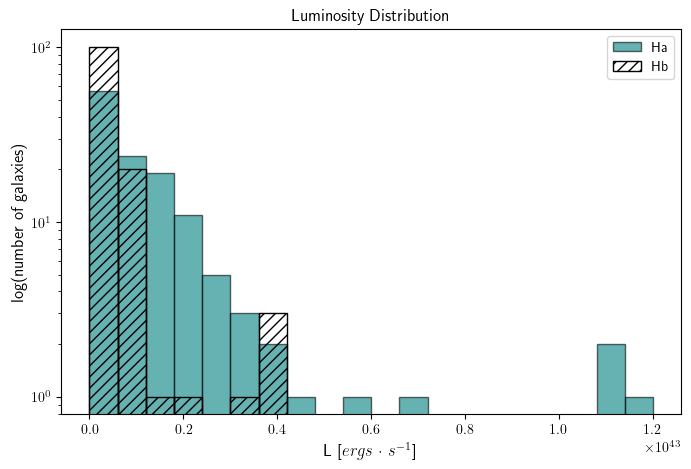

In [5]:
plt.figure(figsize=(8,5))
plt.title('Luminosity Distribution')
plt.xlabel(r'L [$ergs$ $\cdot$ $s^{-1}$]',fontsize=12)
plt.ylabel('log(number of galaxies)',fontsize=12)
plt.hist(sample_df['H-ALPHA INTEGRATED LUMINOSITY'],bins=20,range=[0,1.2*10**43],color='teal',alpha=0.6,edgecolor='black',label='Ha')
plt.hist(sample_df['H-BETA INTEGRATED LUMINOSITY'],bins=20,range=[0,1.2*10**43],fill=False,hatch='///',edgecolor='black',label='Hb')
plt.yscale('log')
plt.legend()
#plt.savefig('name.pdf',dpi=500)
plt.show()

### Flux Sensitivity

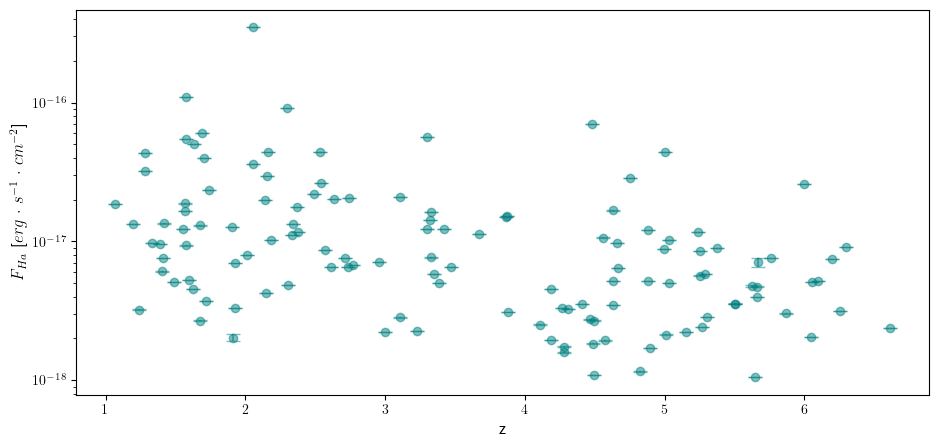

In [7]:
plt.figure(figsize=(11,5))
plt.ylabel(r'$F_{Ha}$ [$erg$ $\cdot$ $s^{-1}$ $\cdot$ $cm^{-2}$]',fontsize=12) # flux
plt.xlabel('z',fontsize=12)
plt.errorbar(sample_df['REDSHIFT'], sample_df['H-ALPHA INTEGRATED FLUX'], yerr=sample_df['H-ALPHA INTEGRATED FLUX MEAN ERROR'], color='teal', alpha=0.5, fmt ='o',markersize=6,capsize=5)
plt.yscale('log')
#plt.legend()
#plt.savefig('redshift_flux.png')
plt.show()

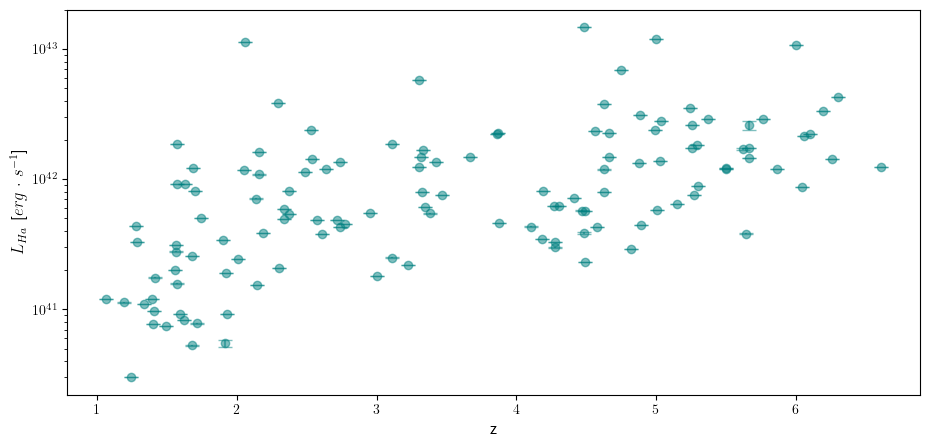

In [8]:
plt.figure(figsize=(11,5))
plt.ylabel(r'$L_{Ha}$ [$erg$ $\cdot$ $s^{-1}$]',fontsize=12) # flux
plt.xlabel('z',fontsize=12)
plt.errorbar(sample_df['REDSHIFT'], sample_df['H-ALPHA INTEGRATED LUMINOSITY'], yerr=sample_df['H-ALPHA INTEGRATED LUMINOSITY MEAN ERROR'], color='teal', alpha=0.5, fmt ='o',markersize=6,capsize=5)
plt.yscale('log')
#plt.legend()
#plt.savefig('redshift_flux.png')
plt.show()

### Comparison of Ha and Hb values

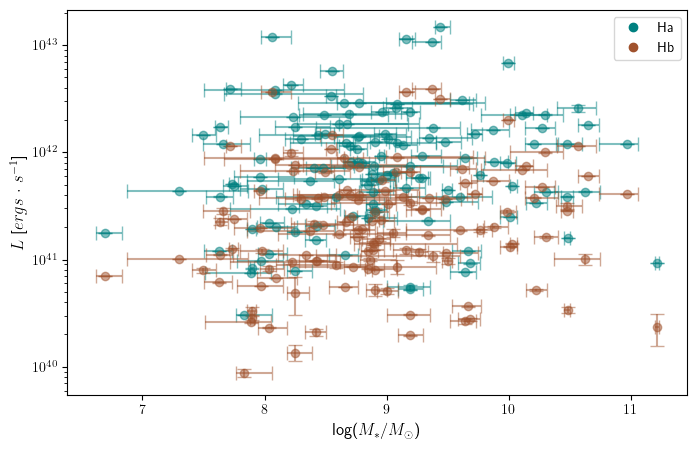

In [10]:
ytop = sample_df['MASS 16% ERROR'] 
ybot = sample_df['MASS 84% ERROR']  

plt.figure(figsize=(8,5))
plt.xlabel(r'log($M_*$/$M_{\odot}$)',fontsize=12)
plt.ylabel('$L$ [$ergs$ $\cdot$ $s^{-1}$]',fontsize=12)
plt.errorbar(sample_df['MASS MEDIAN'], sample_df['H-ALPHA INTEGRATED LUMINOSITY'], xerr=(ytop, ybot), yerr=sample_df['H-ALPHA INTEGRATED LUMINOSITY MEAN ERROR'], color='teal', alpha=0.5, fmt = 'o', markersize=6, capsize=5)
plt.errorbar(sample_df['MASS MEDIAN'], sample_df['H-BETA INTEGRATED LUMINOSITY'], xerr=(ytop, ybot), yerr=sample_df['H-BETA INTEGRATED LUMINOSITY MEAN ERROR'], color='sienna', alpha=0.5, fmt = 'o', markersize=6, capsize=5)

# access legend objects automatically created from data
handles, labels = plt.gca().get_legend_handles_labels()

# create manual symbols for legend
point1 = Line2D([0], [0], label='Ha', marker='o', markersize=6, markerfacecolor='teal', markeredgecolor='teal', linestyle='')
point2 = Line2D([0], [0], label='Hb', marker='o', markersize=6, markerfacecolor='sienna', markeredgecolor='sienna', linestyle='')

# add manual symbols to auto legend
handles.extend([point1, point2])
plt.legend(handles=handles)
plt.yscale('log')
#plt.savefig('Ha_Hb.png',dpi=500)
plt.show()

### UV Luminosity

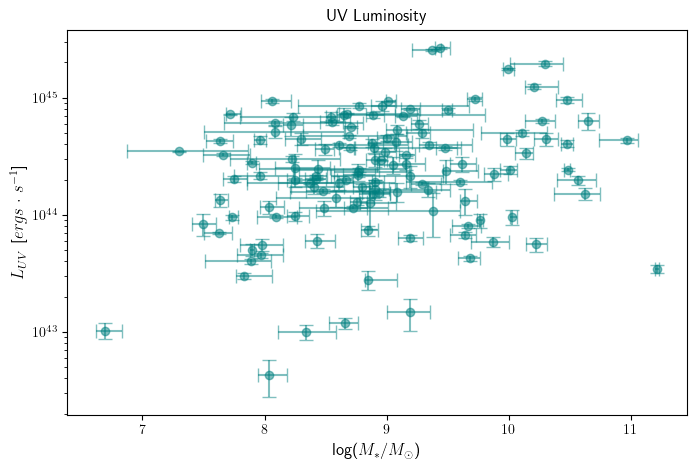

In [12]:
# had to apply np.abs to y_err, look into this
ytop = sample_df['MASS 16% ERROR'] 
ybot = sample_df['MASS 84% ERROR']  

plt.figure(figsize=(8,5))
plt.title('UV Luminosity')
plt.xlabel(r'log($M_*$/$M_{\odot}$)',fontsize=12)
plt.ylabel('$L_{UV}$ [$ergs$ $\cdot$ $s^{-1}$]',fontsize=12) 
plt.errorbar(sample_df['MASS MEDIAN'], sample_df['UV LUMINOSITY DENSITY REST-FRAME'], xerr=(ytop, ybot), yerr=np.abs(sample_df['UV LUMINOSITY DENSITY REST-FRAME ERROR']), color='teal', alpha=0.5, fmt = 'o', markersize=6, capsize=5)
plt.yscale('log')
#plt.legend()
plt.savefig('UV_lum.png',dpi=500)
plt.show()

### Star-Forming Main Sequence Plot

In [16]:
def linear_model(x, m, b):
    return m * x + b

# a dictionary where the keys are the bin values and the values are the corresponding DataFrames
df_split_by_bins = {}

# Iterate over each unique value in 'Z BIN'
bins = sample_df['Z BIN'].unique()
for bin_value in bins:
    # Filter the main DataFrame for each bin_value
    df_split_by_bins[bin_value] = sample_df[sample_df['Z BIN'] == bin_value]

color_list = ['mediumvioletred','darkcyan','mediumpurple','peru']
label_list = ['z = 1 - 2','z = 2 - 4','z = 4 - 6.6']

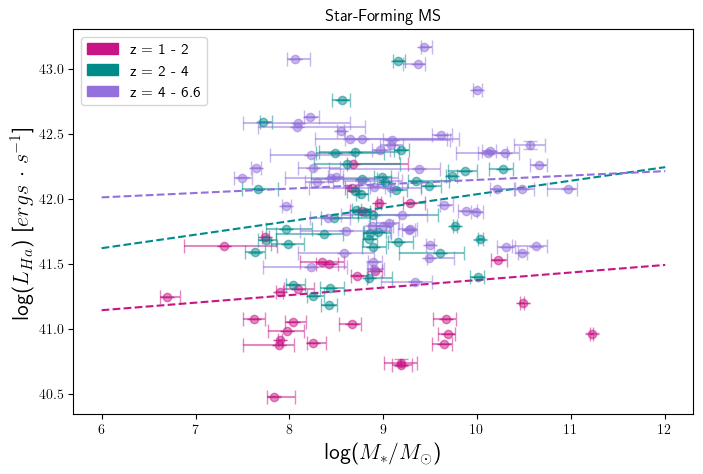

In [18]:
plt.figure(figsize=(8,5))
for i, bin in enumerate(bins):

    # dataframe of current bin
    df = df_split_by_bins[bin]

    # data for current redshift bin
    xtop = df['MASS 16% ERROR']
    xbot = df['MASS 84% ERROR']
    x_data = df['MASS MEDIAN']
    
    # transform to log
    y_data = np.log10(df['H-ALPHA INTEGRATED LUMINOSITY'])
    y_data_err = df['H-ALPHA INTEGRATED LUMINOSITY MEAN ERROR'] / (df['H-ALPHA INTEGRATED LUMINOSITY'] * np.log(10))  # propogate error

    # regression line
    x_arr = np.linspace(6, 12, 100).reshape((-1, 1))
    y_arr = linear_model(x_arr, df['SFMS SLOPE'].iloc[0], df['SFMS INTERCEPT'].iloc[0]) 

    # plotting
    plt.errorbar(x_data, y_data, xerr=(xtop, xbot), yerr=y_data_err, color=color_list[i], alpha=0.5, fmt = 'o', markersize=6, capsize=5)
    plt.plot(x_arr, y_arr, color=color_list[i], linestyle='--')

plt.title('Star-Forming MS')
plt.xlabel(r'log($M_*$/$M_{\odot}$)',fontsize=16)
plt.ylabel(r'log($L_{Ha}$) [$ergs$ $\cdot$ $s^{-1}$]',fontsize=16)

# access legend objects automatically created from data
handles, labels = plt.gca().get_legend_handles_labels()
patch1 = mpatches.Patch(color=color_list[0], label=label_list[0])   
patch2 = mpatches.Patch(color=color_list[1], label=label_list[1]) 
patch3 = mpatches.Patch(color=color_list[2], label=label_list[2]) 
#patch4 = mpatches.Patch(color=color_list[3], label=label_list[3]) 
handles.extend([patch1, patch2, patch3])
plt.legend(handles=handles,prop={'size': 11},loc='upper left')
plt.savefig('SFMS_current.png',dpi=500)
plt.show()

### SFR(H-alpha)

In [21]:
def redshift_to_age(z):
    '''
    Converting z to t (age of the universe at given redshift)
    '''
    age = cosmo.age(z)
    return age.to(u.Gyr).value  # Convert the age to gigayears and return the value without units

def SFR_mass(log_mass,z):
    '''
    SFMS curve from Popesso et al. 2023 (eq. 10)
    Note, resulting SFR is in terms of [solar mass / yr]
    '''
    a_0 = 0.20
    a_1 = -0.034
    b_0 = -26.134
    b_1 = 4.722
    b_2 = -0.1925
    t = redshift_to_age(z)
    
    SFR = ((a_1 * t) + b_1) * log_mass + (b_2*(log_mass)**2) + (b_0 + (a_0 * t))
    return SFR

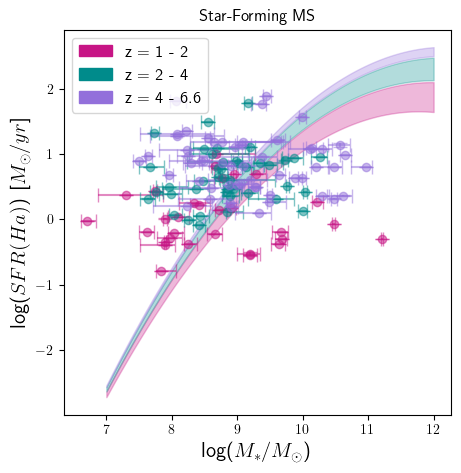

In [23]:
plt.figure(figsize=(5,5))
for i, bin in enumerate(bins):

    # dataframe of current bin
    df = df_split_by_bins[bin]

    # data for current redshift bin
    xtop = df['MASS 16% ERROR']
    xbot = df['MASS 84% ERROR']
    x_data = df['MASS MEDIAN']
    
    # transform to log
    y_data = np.log10(df['H-ALPHA SFR'])
    y_err = df['H-ALPHA SFR ERROR'] / (df['H-ALPHA SFR'] * np.log(10))  # propogate error

    # theoretical SFR
    z_min = np.min(df['REDSHIFT'])
    z_max = np.max(df['REDSHIFT'])
    x_arr = np.linspace(7, 12, 100).reshape((-1, 1))
    y_theor_min = SFR_mass(x_arr,z_min)  
    y_theor_max = SFR_mass(x_arr,z_max) 

    # plotting
    plt.errorbar(x_data, y_data, xerr=(xtop, xbot), yerr=y_err, color=color_list[i], alpha=0.5, fmt = 'o', markersize=6, capsize=5)
    #plt.plot(x_arr, y_theor_min, color='black', linestyle='--')  # theoretical SFMS (Popesso 2023)
    #plt.plot(x_arr, y_theor_max, color='black', linestyle='--')  # theoretical SFMS (Popesso 2023)
    plt.fill_between(x_arr.flatten(), y_theor_min.flatten(), y_theor_max.flatten(), color=color_list[i], alpha=0.3)

plt.title('Star-Forming MS')
plt.xlabel(r'log($M_*$/$M_{\odot}$)',fontsize=15)
plt.ylabel(r'log($SFR(Ha)$) [$M_{\odot}/yr$]',fontsize=15)

# access legend objects automatically created from data
handles, labels = plt.gca().get_legend_handles_labels()
patch1 = mpatches.Patch(color=color_list[0], label=label_list[0])   
patch2 = mpatches.Patch(color=color_list[1], label=label_list[1]) 
patch3 = mpatches.Patch(color=color_list[2], label=label_list[2]) 
#patch4 = mpatches.Patch(color=color_list[3], label=label_list[3]) 
handles.extend([patch1, patch2, patch3])
plt.legend(handles=handles,prop={'size': 12},loc='upper left')
plt.savefig('SFMS_popesso.png',dpi=500)
plt.show()

### Luminosity Ratio

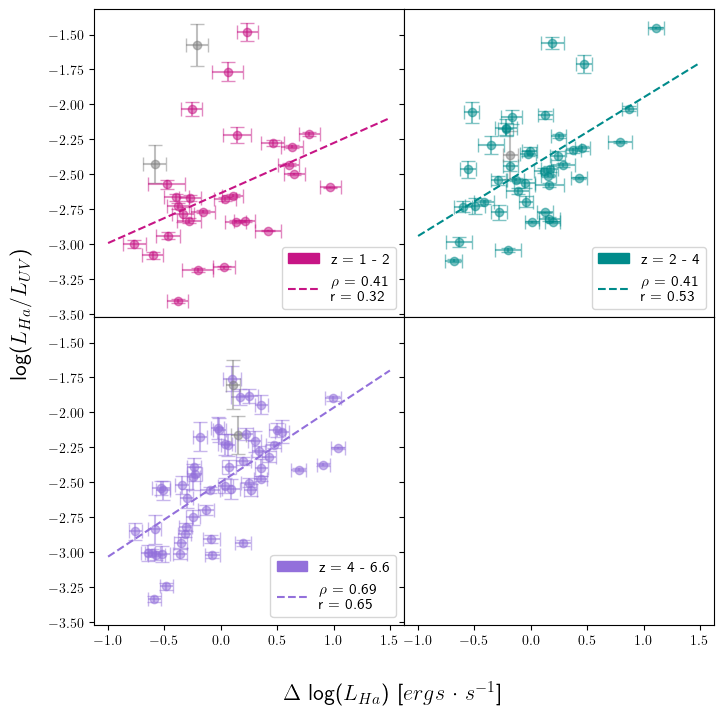

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
fig.supxlabel(r'$\Delta$ log($L_{Ha}$) [$ergs$ $\cdot$ $s^{-1}$]', fontsize=16)
fig.supylabel(r'log($L_{Ha}$/$L_{UV}$)', fontsize=16)

for i, bin in enumerate(bins):
    ax = axs[i//2, i%2]
    
    # dataframe of current bin
    df = df_split_by_bins[bin]

    # Calculate Pearson's correlation coefficient
    y_data = df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO'].tolist()
    x_data = df['RESIDUALS'].tolist()
    spearman_corr, p_val = spearmanr(x_data, y_data)
    pearson_corr, p_value = pearsonr(x_data, y_data)

    # regression line
    x_arr = np.linspace(-1, 1.5, 100).reshape((-1, 1))
    y_arr = linear_model(x_arr, df['LUMINOSITY RATIO VS RESIDUAL SLOPE'].iloc[0], df['LUMINOSITY RATIO VS RESIDUAL INTERCEPT'].iloc[0])
    ax.plot(x_arr, y_arr, color=color_list[i], linestyle='--')

    # looping through each source
    for source in range(len(df)):
    
        log_lum_ratio = df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO'].iloc[source]
        log_lum_ratio_err = df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO ERROR'].iloc[source]
        res = df['RESIDUALS'].iloc[source]
        res_err = df['RESIDUALS ERROR'].iloc[source]
    
        if df['FLAG'].iloc[source] == True:
            ax.errorbar(res, log_lum_ratio, xerr=res_err, yerr=log_lum_ratio_err, color='grey', alpha=0.5, fmt='o', markersize=6, capsize=5)
        
        else:
            ax.errorbar(res, log_lum_ratio, xerr=res_err, yerr=log_lum_ratio_err, color=color_list[i], alpha=0.5, fmt='o', markersize=6, capsize=5)

    # access legend objects automatically created from data
    handles, labels = plt.gca().get_legend_handles_labels()
    patch1 = mpatches.Patch(color=color_list[i], label=label_list[i])
    patch2 = Line2D([0], [0], color=color_list[i], linestyle='--', label=r'$\rho$ = ' + str(round(spearman_corr,2)) + '\n r = ' + str(round(pearson_corr,2)))
    handles.extend([patch1, patch2])
    ax.legend(handles=handles,prop={'size': 11},loc='lower right')

plt.subplots_adjust(wspace=0, hspace=0)  
plt.savefig('lum_ratio.png',dpi=500)
plt.show()